# 一维Lax激波管

[![下载Notebook](https://mindspore-website.obs.cn-north-4.myhuaweicloud.com/website-images/master/resource/_static/logo_notebook.png)](https://obs.dualstack.cn-north-4.myhuaweicloud.com/mindspore-website/notebook/master/mindflow/zh_cn/cfd/mindspore_lax_tube.ipynb)&emsp;[![下载样例代码](https://mindspore-website.obs.cn-north-4.myhuaweicloud.com/website-images/master/resource/_static/logo_download_code.png)](https://obs.dualstack.cn-north-4.myhuaweicloud.com/mindspore-website/notebook/master/mindflow/zh_cn/cfd/mindspore_lax_tube.py)&emsp;[![查看源文件](https://mindspore-website.obs.cn-north-4.myhuaweicloud.com/website-images/master/resource/_static/logo_source.png)](https://gitee.com/mindspore/docs/blob/master/docs/mindflow/docs/source_zh_cn/cfd/lax_tube.ipynb)

本案例要求**MindSpore版本 >= 2.0.0**调用如下接口: *mindspore.jit，mindspore.jit_class*。

激波管问题是检验计算流体代码准确性的常见问题。这个案例为一个一维黎曼问题，即理想气体在左右端不同条件下的发展问题。

## 问题描述

Lax激波管问题的定义为:

$$
\frac{\partial}{\partial t} \left(\begin{matrix} \rho \\ \rho u \\ E \\\end{matrix} \right) + \frac{\partial}{\partial x} \left(\begin{matrix} \rho u \\ \rho u^2 + p \\ u(E + p) \\\end{matrix} \right) = 0
$$

$$
E = \frac{\rho}{\gamma - 1} + \frac{1}{2}\rho u^2
$$

其中，对理想气体， $\gamma = 1.4$ ，初始条件为：

$$
\left(\begin{matrix} \rho \\ u \\ p \\\end{matrix}\right)_{x<0.5} = \left(\begin{matrix} 0.445 \\ 0.698 \\ 3.528 \\\end{matrix}\right), \quad
\left(\begin{matrix} \rho \\ u \\ p \\\end{matrix}\right)_{x>0.5} = \left(\begin{matrix} 0.5 \\ 0.0 \\ 0.571 \\\end{matrix}\right)
$$

在激波管两端，施加第二类边界条件。

本案例中`src`包可以在[src](https://gitee.com/mindspore/mindscience/tree/master/MindFlow/applications/cfd/lax/src)下载。


In [1]:
from mindspore import context
from mindflow import load_yaml_config, vis_1d
from mindflow import cfd
from mindflow.cfd.runtime import RunTime
from mindflow.cfd.simulator import Simulator

from src.ic import lax_ic_1d

context.set_context(device_target="GPU", device_id=3)

## 定义Simulator和RunTime

网格、材料、仿真时间、边界条件和数值方法的设置在文件[numeric.yaml](https://gitee.com/mindspore/mindscience/blob/master/MindFlow/applications/cfd/lax/numeric.yaml) 中。

In [2]:
config = load_yaml_config('numeric.yaml')
simulator = Simulator(config)
runtime = RunTime(config['runtime'], simulator.mesh_info, simulator.material)

## 初始条件

根据网格坐标确定初始条件。

In [3]:
mesh_x, _, _ = simulator.mesh_info.mesh_xyz()
pri_var = lax_ic_1d(mesh_x)
con_var = cfd.cal_con_var(pri_var, simulator.material)

## 执行仿真

随时间推进执行仿真。

In [4]:
while runtime.time_loop(pri_var):
    pri_var = cfd.cal_pri_var(con_var, simulator.material)
    runtime.compute_timestep(pri_var)
    con_var = simulator.integration_step(con_var, runtime.timestep)
    runtime.advance()

current time = 0.000000, time step = 0.001117
current time = 0.001117, time step = 0.001107
current time = 0.002224, time step = 0.001072
current time = 0.003296, time step = 0.001035
current time = 0.004332, time step = 0.001016
current time = 0.005348, time step = 0.001008
current time = 0.006356, time step = 0.000991
current time = 0.007347, time step = 0.000976
current time = 0.008324, time step = 0.000966
current time = 0.009290, time step = 0.000960
current time = 0.010250, time step = 0.000957
current time = 0.011207, time step = 0.000954
current time = 0.012161, time step = 0.000953
current time = 0.013113, time step = 0.000952
current time = 0.014066, time step = 0.000952
current time = 0.015017, time step = 0.000951
current time = 0.015969, time step = 0.000951
current time = 0.016920, time step = 0.000952
current time = 0.017872, time step = 0.000951
current time = 0.018823, time step = 0.000951
current time = 0.019775, time step = 0.000952
current time = 0.020726, time step

## Post Processing

您可以对密度、压力、速度进行可视化。

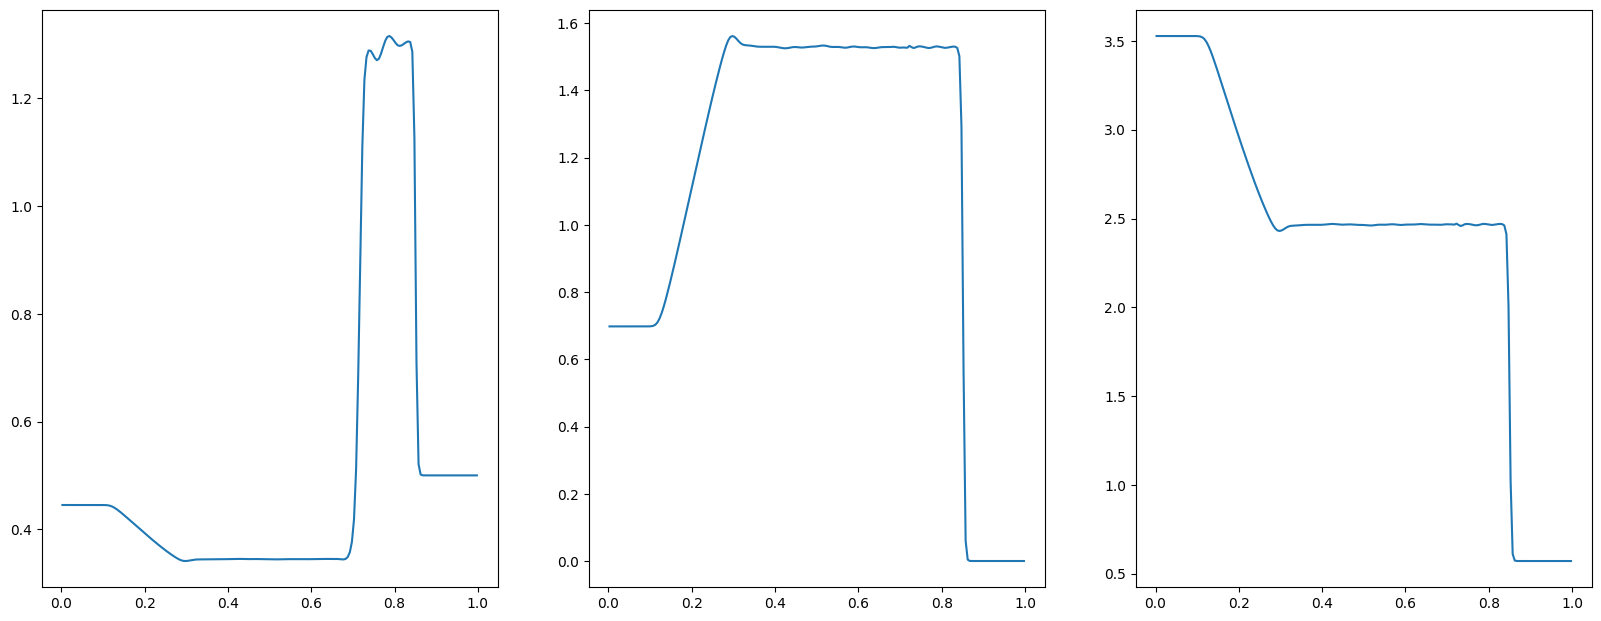

In [5]:
pri_var = cfd.cal_pri_var(con_var, simulator.material)
vis_1d(pri_var, 'lax.jpg')